<i>Is it financially optimal to buy a car in cash?</i>

Answers to this question are mixed. I asked my bank lender (they said cash is optimal), but, <a href="https://www.fool.com/retirement/2017/12/24/why-you-shouldnt-buy-a-car-in-cash.aspx">this article</a>, for example, thinks the answer is no. The primary reason why people think buying a car in cash is optimal: to avoid paying interest on an auto loan. But this ignores a concept economists have realized for some time:

<b>OPPORTUNITY COST</b>

A loan allows you to hold on to your cash _longer_ and have it generate revenue by an investment. If that investment exceeds the interest of an auto loan, then it's better to get a loan (of course, if you would have to deplete your  emergency funds, than you should probably get a loan).

Is this _always_ the case? I didn't find any detailed quantitative arguments. So I decided to construct the answer myself.

Let's review and derive some of the fundamentals we need to answer this question.

# Simple Interest

What makes simple interest, well--simple, is that the calculation is straightforward. Here's how it works. First, we need to introdude some notation:

$P$ [<b>Principal</b><i>: the initial amount invested</i>]

$t$ [<b>Time</b>: <i>in years</i>]

$r$ [<b>Interest Rate</b><i>: the rate of return--typically annualized (that is, interest rate over one year</i>)

$A$ [<b>Amount Due</b>:<i>principal plus cash made from interest</i>]

Let's analyze how interest is generated. At the beginning, all we have is is the principal:

$A(t=0) = P$

Then, after one year, we'll still have our principal. But we'll also have generated some interest:

$A(t=1) = P + Pr = P(1 + r)$

$A(t=2) = P + Pr + Pr = P(1 + 2r)$

...

$A = P(1 + rt)$

You can use mathematical induction to prove this formally. As an example, banks typically charge for auto loans using simple interest.

# Compound Interest
Compound interest takes the interest yielded and adds it back into the principal. We keep repeating this. Say after one year...

$A(t = 1) = P + rP$

$A(t = 2) = P + r A(t=1) = r(rP) = P + r^2P = P(1 + r^2)$

$A(t = 3) = P + r A(t=2) = r r A(t=1) = P(1 + r^3)$

...

$A = P(1 + r^t)$

However, we assumed that this compounding occurs once a year. What if we compounded at an arbitrary frequency? (e.g. monthly, daily). The modified formula for this would be:

$A = P(1 + (\frac{r}{n})^{nt})$

If we let take the limit and let n -> 0, we'd find (transform to log space and use L`Hopitals rules):

$A = e^{rt}$

That is, the natural _e_ arises!

We can write a python function to calculate this for us:

In [1]:
def get_compound_interest(P, t, r):
    """Calculates compound interest
    
    P (initial principal)
    t (time in months)
    r (percentage rate)
    """
    return P * ((1. + (r / 100.))**(t / 12.) - 1.)

# Amortization
When we make montly payments on our auto loan, our montly payment is the sum of paying down our principal and the auto loan interest. But, this distribution changes over time. You pay more interest at first. The derivation is a bit involved (see http://people.cs.uchicago.edu/~jagolbec/cspp536/amort/ ). But what we need from it, is the math that works our exactly what this monthly payment would be given the principal, rate, and number of months of the loan. This formula is:

$M = P\left(\frac{1 - (1 + r)}{1 - (1 + r)^n} + r \right)$

We can write a function for this in Python

In [3]:
def get_monthly_payment(P, t, r):
    """ See http://people.cs.uchicago.edu/~jagolbec/cspp536/amort/
        for derivation
        
    P (initial principal)
    t (time in months)
    r (percentage rate)
    """
    if t < 0 or P == 0.:
        return 0.
    
    r = r / (100. * 12.)
    a = 1. - (1. + r)
    b = 1. - (1. + r)**t
    M = P * (a / b + r)
    return M

And with this function, we can easily write another function to calculate total auto interest paid:

In [4]:
def get_auto_loan_interest(P, t, r):
    if t < 0 or P == 0.:
        return 0.
    
    M = get_monthly_payment(P, t, r)
    I = M * t - P
    return I

# APY
A frustating point is trying to compare loans at different compounding frequencies and rates. Fortunately, a normalization technique, is to compute the effective compound interest rate supposing we _had_ compunded yearly. This is known as an APY (annual percentange yield).

# Model

We want to maximize the cash we'll have in the bank under the condition that we _have_ to purchase the vehicle. The loans we have to choose from will likely have different terms, and auto interest rates.

To compare all scenarios on an equal footing, let's assume you have cash to buy the car (denoted as $K_{car}$) plus an amount equal to the auto loan with the highest interest--denoted as $K^{*}_{I}$ (and of course, extra cash for emergency funds--but we won't model this--it's always assumed).

We will compare gains at the same time point in time. We'll choose as the largest term out of all loans offered (denoted as $t^{*}$. Time will always be in units of months.

Let's calculate our bank account at several time steps:

$A(0) = K_{car} + K^{*}_{I} - C_{down payment}$

The above term makes sense. It's the cash we have minus the downpayment. Note if we paid cash, then we'd have:

$A(0) = K^{*}_{I}$

But now, fast forward one month:

$A(1) = A(0) + R(1) - C_{p}(1) - C_{i}(1)$

What the above equations says, is we have our balance at $A(0)$ plus the revenue we generated from having that cash (i.e., $R(1)$). But then we have to pay out our principal and interest ($C_{p}(1)$ and $C_{i}(1)$ respectively). And notice these quantities are functions of _time_. That is, each month their respective values will change. Finally, at the last time period, we'll have:

$A(t^*) = A(t^* - 1) + R(t^*) - C_{p}(t^*) - C_{i}(t^*)$

Now, $C_{p}(t^*) - C_{i}(t^*)$ will always equal a fixed amount (i.e., monthly payment).

# Revenue Calculation
A complication in calculating revenue generated from interest, is that our principal, in general, is not fixed in time. If we take a loan, we have monthly payments drafted out of our account. I think a straightforward way to deal with this, is to calculate the revenue had we not deducted monthly payments. Then adjust accordingly.

For example, suppose our balance at t=0 is \\$100 and we take \\$10 payments out each month. Our balance over time (we are separating out initial principal from revenue generated) will look like the following:

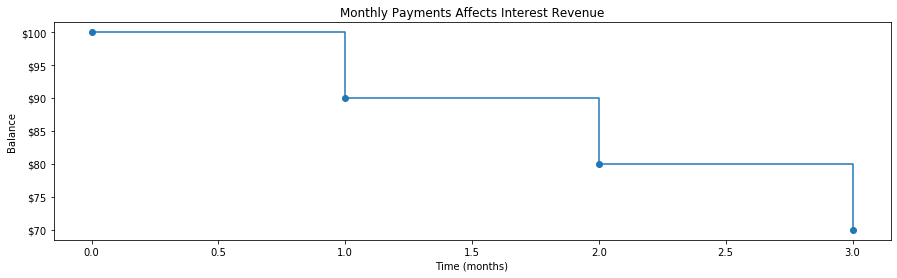

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

# Initial balance, monthly payment, time in months
A0, M, t = 100, 10., range(0, 4)

_, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.step(t, [A0 - i * 10. for i in t], where='post', marker='o')
plt.title('Monthly Payments Affects Interest Revenue')
plt.ylabel('Balance')
plt.xlabel('Time (months)')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) 
plt.show()

Let's think about t=3 (i.e., 3 months in). At this point, we have \\$70. But let's pretend we never made monthly payments. I'll denote $R_b(t)$ as the revenue generated pretending we never drafted payments. But this overcounts. To adjust, let $R_m(t)$ be the revenue generated from the amount equal to a monthly payment over t months. To calculate the revenue then, it's:

$R(t=3) = R_b(t=3) - R_m(t=1) - R_m(t=2)$

This works because at t=3, the first monthly payment means we lost out on that revenue that could have been had it sat there for two months. And the second payment means we lost out on revenue that would have been generated out of one month.

In general:

$R(t) = R_b(t) - \sum_j^{t-1} R_m(j)$

Let's wrap this up into a python function:

In [6]:
def get_revenue(P, t, r, M):
    Rb = get_compound_interest(P, t, r)
    Rm = sum([get_compound_interest(M, j, r) for j in range(1, t)])
    R = Rb - Rm
    return R

Now, let's put this all together to generate how our balance and revenue change over time. When we have these, we can plot two scenarios: one where we took the loan and the other where we paid in cash. The best option will be the one that yields the highest balance in our account.

In [7]:
def get_monthly_breakdown(car, I_star, downpayment,
                          apy, r, term, T):
    
    # Cacluate the monthly payment
    M = get_monthly_payment(car - downpayment,
                            term,
                            r)
    
    # Starging balance and revenue
    A0 = car + I_star - downpayment
    result = {'revenue': [0.],
              'balance': [A0],
              'time': [0.]}
    
    # For each month...
    A = A0
    for t in range(1, T + 1):
        R = get_revenue(A0, t, apy, M)
        A = A - M if t <= term else A
        
        result['revenue'].append(R)
        result['balance'].append(A + R)
        result['time'].append(t)        
    return result

def plot_result(cash_result, loan_result, T):
    plt.clf()
    _, ax = plt.subplots(1, 1, figsize=(15, 4))
    
    t = cash_result['time']
    
    plt.step(t, cash_result['balance'], color='darkgreen',
             where='post', label='Balance (Cash Method)', alpha=0.6)
    
    plt.step(t, loan_result['balance'], color='darkgray',
             where='post', label='Balance (Loan Method)', alpha=0.6)
    
    plt.legend()
    
    c, l = cash_result['balance'][-1], loan_result['balance'][-1]
    
    
    plt.title('At {} months, balance would be:\n' \
              '${:,.2f} (Cash Method)\n ${:,.2f} (Loan Method)'.format(t[-1], c, l))
    plt.ylabel('Dollars ($)')
    plt.xlabel('Time (months)')
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) 
    plt.show()

Now, let's put in some concrete numbers

<Figure size 432x288 with 0 Axes>

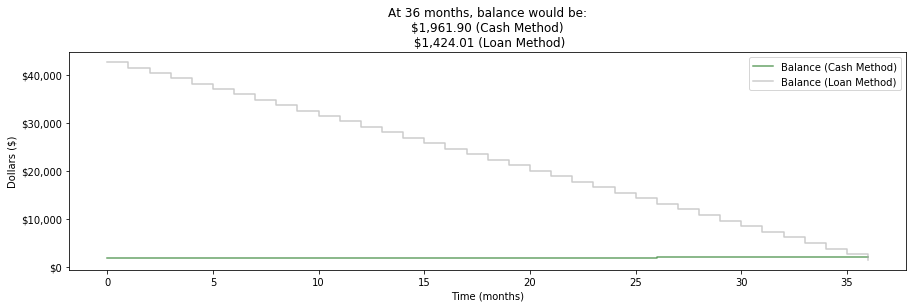

In [8]:
car = 53000.
downpayment = 12200.0
term = 36
T = 36
r = 2.89
apy = 2.1
I_star = get_auto_loan_interest(car - downpayment, term, r)

loan_result = get_monthly_breakdown(car=car,
                                    I_star=I_star,
                                    downpayment=downpayment,
                                    apy=apy,
                                    r=r,
                                    term=term,
                                    T=T)

cash_result = get_monthly_breakdown(car=car,
                                    I_star=I_star,
                                    downpayment=car,
                                    apy=apy,
                                    r=r,
                                    term=term,
                                    T=T)

plot_result(cash_result, loan_result, T + 1)

Assuming there are no mistakes in my code (nor mistakes in the derivation), it seems for this scenario, it's actually better to pay in cash. We could lower the auto loan rate a bit more to find a situation where taking a loan is better:

<Figure size 432x288 with 0 Axes>

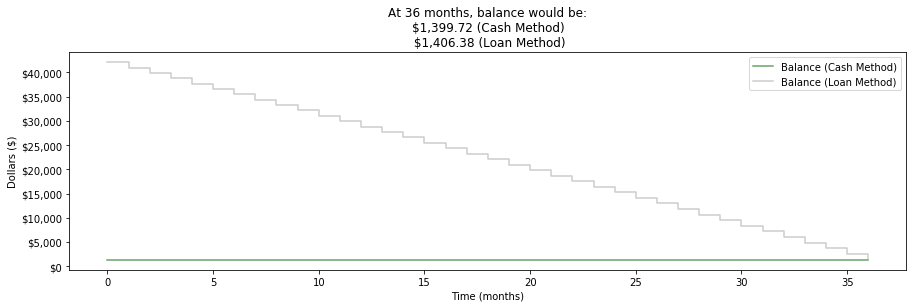

In [9]:
r = 2.07
I_star = get_auto_loan_interest(car - downpayment, term, r)

loan_result = get_monthly_breakdown(car=car,
                                    I_star=I_star,
                                    downpayment=downpayment,
                                    apy=apy,
                                    r=r,
                                    term=term,
                                    T=T)

cash_result = get_monthly_breakdown(car=car,
                                    I_star=I_star,
                                    downpayment=car,
                                    apy=apy,
                                    r=r,
                                    term=term,
                                    T=T)

plot_result(cash_result, loan_result, T + 1)

We can think of the auto loan reaching a critical point where taking the loan would be optimal (same argument applies to other parameters) 

# Comparing Loans
Now, for the finale, let's construct a function that allows a user to enter the different types of loans offered, and have it pick the optimal decision.

In [10]:
def get_outcomes(car, apy, loans):
    # Find longest term offered
    T = max([l['term'] for l in loans])
    
    # Find loan with largest interest
    I_star = max([get_auto_loan_interest(car - l['downpayment'], l['term'], l['apr'])
                  for l in loans])
    
    def get_name(l):
        return ''.join(['{}_{}_'.format(k,v) for k,v in l.items()])
        
    y = []
    for l in loans:
        result = get_monthly_breakdown(car, I_star, l['downpayment'],
                                       apy, l['apr'], l['term'], T)
        y.append((get_name(l), result['balance'][-1]))
        
    return y

In [11]:
car = 53000.
apy = 2.1
loans = [{'term': 60, 'apr': 3.89, 'downpayment': 8000.},
         {'term': 36, 'apr': 2.89, 'downpayment': 12200.0},
         {'term': 0, 'apr': 0, 'downpayment': car}]

get_outcomes(car, apy, loans)

[('term_60_apr_3.89_downpayment_8000.0_', 2807.4344508792274),
 ('term_36_apr_2.89_downpayment_12200.0_', 3958.7110204710066),
 ('term_0_apr_0_downpayment_53000.0_', 5093.390593279506)]

Given these numbers, paying in cash would again be the optimal decision.